# Chest X-ray dataset
CNN are widely used for image analysis as they are known to be able to find patterns in images. Base of the CNNs are the convolutional layers. In each convolution layers, we will multiply the input image with some filters and the output for each block of filter is going to be one number which is going to be saved and then the filtr will move to the next block.

In [ ]:
import pandas as pd
import numpy as np
import cv2
import sklearn
import random
import matplotlib.pyplot as plt
import random  # for shuffling and sampling
from tqdm import tqdm  # to visualize long-running operations
from collections import Counter
import shutil
import os

import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

## Show some image samples

Normal Images:


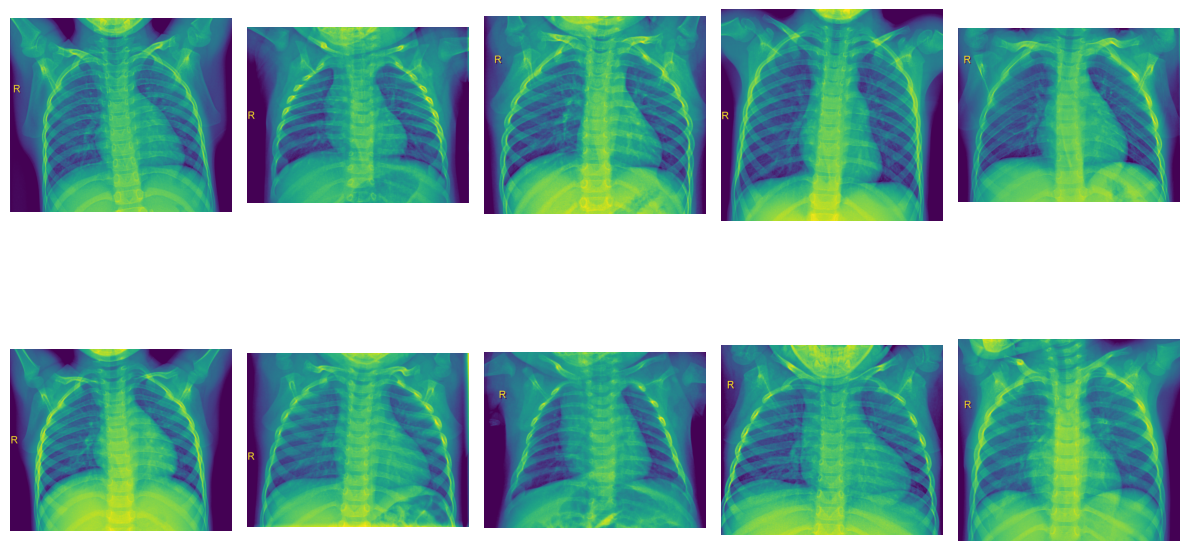

Pneumonia Images:


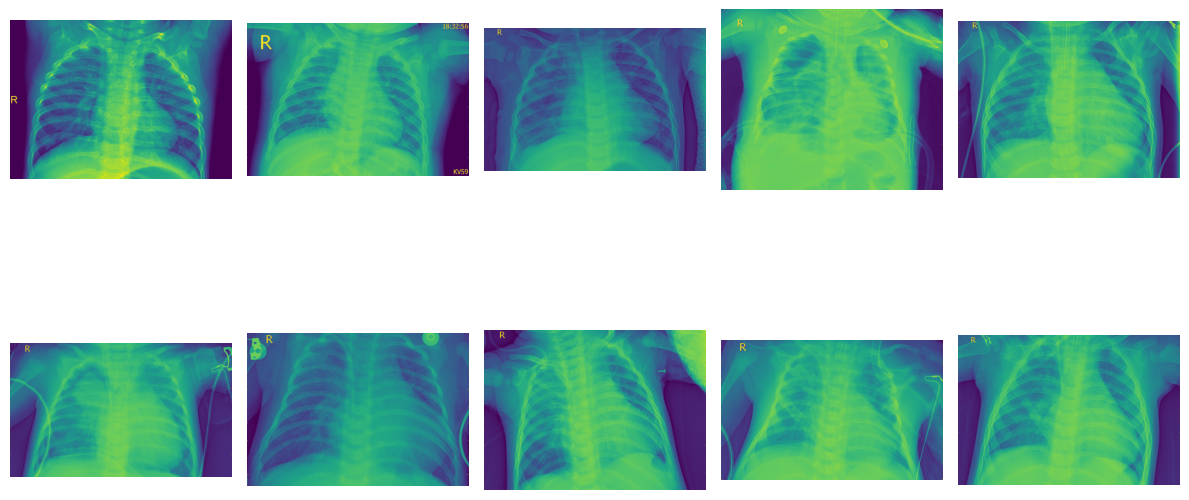

In [ ]:
root_dir = "/home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/data/chest_xray"

train_normal_folder_path = root_dir + "/train/NORMAL/"
train_pneumonia_folder_path = root_dir + "/train/PNEUMONIA/"

test_normal_folder_path = root_dir + "/test/NORMAL/"
test_pneumonia_folder_path = root_dir + "/test/PNEUMONIA/"

val_normal_folder_path = root_dir + "/val/NORMAL/"
val_pneumonia_folder_path = root_dir + "/val/PNEUMONIA/"

for folder_path in [train_normal_folder_path, train_pneumonia_folder_path]:
    if folder_path == train_normal_folder_path:
        print("Normal Images:")
    else:
        print("Pneumonia Images:")
    # List all JPEG files
    all_images = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg') or f.lower().endswith('.jpeg')]

    # Pick a few random examples
    num_samples = 10  # adjust how many images you want to show
    sample_images = random.sample(all_images, min(num_samples, len(all_images)))

    # Grid settings
    cols = 5
    rows = (len(sample_images) + cols - 1) // cols

    plt.figure(figsize=(12, 8))
    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Fix test and validation split

I needed to do the following only once becasue the number of val images was small. So I combined the test and val images and then I split it again.

In [ ]:
# # --- Paths ---
# root_dir = "/home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/data/chest_xray"

# folders = {
#     "train_normal": os.path.join(root_dir, "train/NORMAL"),
#     "train_pneumonia": os.path.join(root_dir, "train/PNEUMONIA"),
#     "test_normal": os.path.join(root_dir, "test/NORMAL"),
#     "test_pneumonia": os.path.join(root_dir, "test/PNEUMONIA"),
#     "val_normal": os.path.join(root_dir, "val/NORMAL"),
#     "val_pneumonia": os.path.join(root_dir, "val/PNEUMONIA"),
# }

# # --- Helper function to move images safely ---
# def move_images(img_list, src_folder, dst_folder, overwrite_threshold=20):
#     if len(os.listdir(dst_folder)) <= overwrite_threshold:
#         for img in img_list:
#             src_path = os.path.join(src_folder, img)
#             dst_path = os.path.join(dst_folder, img)
#             if not os.path.exists(src_path):
#                 print(f"Skipping missing file: {src_path}")
#                 continue
#             if os.path.exists(dst_path):
#                 os.remove(dst_path)  # overwrite small val folder
#             shutil.move(src_path, dst_path)
#     else:
#         print(f"Destination folder {dst_folder} has more than {overwrite_threshold} images. Skipping move.")

# # --- Combine test + val for splitting ---
# def combine_and_split(test_folder, val_folder, test_ratio=0.5):
#     test_files = set(os.listdir(test_folder))
#     val_files = set(os.listdir(val_folder))
    
#     combined_files = list(test_files | val_files)  # union, avoids duplicates
    
#     # Split
#     new_val, new_test = train_test_split(combined_files, test_size=test_ratio, random_state=42)
    
#     # Move files
#     move_images(new_val, test_folder, val_folder)
#     # Remaining files in test_folder after moving val become the new test set
#     remaining_test_files = set(os.listdir(test_folder))
#     files_to_keep = set(new_test) & remaining_test_files  # only files that still exist
#     # Remove any extra files in test folder (shouldn't happen if careful)
#     for f in remaining_test_files - files_to_keep:
#         os.remove(os.path.join(test_folder, f))

# # --- Process Normal and Pneumonia ---
# combine_and_split(folders["test_normal"], folders["val_normal"])
# combine_and_split(folders["test_pneumonia"], folders["val_pneumonia"])

# print("Dataset reorganized successfully!")

In [ ]:
# Cound number of images in each folder
for folder_path in [train_normal_folder_path, train_pneumonia_folder_path,
                    test_normal_folder_path, test_pneumonia_folder_path,
                    val_normal_folder_path, val_pneumonia_folder_path]:
    if "NORMAL" in folder_path:
        label = "Normal"
    else:
        label = "Pneumonia"
    
    if 'train' in folder_path:
        dataset_type = "Training"
    elif 'test' in folder_path:
        dataset_type = "Testing"
    else:
        dataset_type = "Validation"

    num_images = len([f for f in os.listdir(folder_path) if f.lower().endswith('.jpg') or f.lower().endswith('.jpeg')])
    print(f"{dataset_type} {label} Images: {num_images}")

Training Normal Images: 1341
Training Pneumonia Images: 3875
Testing Normal Images: 110
Testing Pneumonia Images: 191
Validation Normal Images: 131
Validation Pneumonia Images: 207


# Make sure that test and val images dont exist in train images

In [ ]:
root_dir = "/home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/data/chest_xray"

folders = {
    "train_normal": os.path.join(root_dir, "train/NORMAL"),
    "train_pneumonia": os.path.join(root_dir, "train/PNEUMONIA"),
    "test_normal": os.path.join(root_dir, "test/NORMAL"),
    "test_pneumonia": os.path.join(root_dir, "test/PNEUMONIA"),
    "val_normal": os.path.join(root_dir, "val/NORMAL"),
    "val_pneumonia": os.path.join(root_dir, "val/PNEUMONIA"),
}

def check_no_overlap(train_folder, other_folders):
    train_files = set(os.listdir(train_folder))
    for folder in other_folders:
        other_files = set(os.listdir(folder))
        overlap = train_files & other_files
        if overlap:
            print(f"Overlap found between {train_folder} and {folder}:")
            print(overlap)
        else:
            print(f"No overlap between {train_folder} and {folder}")

# Check Normal
check_no_overlap(folders["train_normal"], [folders["val_normal"], folders["test_normal"]])

# Check Pneumonia
check_no_overlap(folders["train_pneumonia"], [folders["val_pneumonia"], folders["test_pneumonia"]])

Overlap found between /home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/data/chest_xray/train/NORMAL and /home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/data/chest_xray/val/NORMAL:
{'.DS_Store'}
No overlap between /home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/data/chest_xray/train/NORMAL and /home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/data/chest_xray/test/NORMAL
Overlap found between /home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/data/chest_xray/train/PNEUMONIA and /home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/data/chest_xray/val/PNEUMONIA:
{'.DS_Store'}
No overlap between /home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/data/chest_xray/train/PNEUMONIA and /home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/data/chest_xray/test/PNEUMONIA


There is no overlap, so we are safe to proceed

## Loading and preprocessing images

1- convert to grayscale (color is not necessary for X-rays)

2- Resize to 224 x 224 (uniform size)

3- Normalize pixel values to [0,1] range

In [ ]:
# Lets check image modes and sizes
for folder_path in [train_normal_folder_path, train_pneumonia_folder_path,
             test_normal_folder_path, test_pneumonia_folder_path,
             val_normal_folder_path, val_pneumonia_folder_path]:
    
    if "NORMAL" in folder_path:
        label = "Normal"
    else:
        label = "Pneumonia"
    
    if 'train' in folder_path:
        dataset_type = "Training"
    elif 'test' in folder_path:
        dataset_type = "Testing"
    else:
        dataset_type = "Validation"
    print(f"\n{dataset_type} {label} Images Info:")
    print("-" * 40)
    
    image_info = []
    all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg'))]

    for img_file in all_images:
        img_path = os.path.join(folder_path, img_file)
        with Image.open(img_path) as img:
            width, height = img.size
            mode = img.mode
            image_info.append({
                'Image': img_file,
                'Mode': mode,
                'Width': width,
                'Height': height
            })

    image_modes_and_sizes = pd.DataFrame(image_info)
    print(image_modes_and_sizes.Mode.value_counts().reset_index())
    print(image_modes_and_sizes[['Width', 'Height']].head(3))


Training Normal Images Info:
----------------------------------------
  Mode  count
0    L   1341
   Width  Height
0   1920    1750
1   1388    1063
2   1816    1607

Training Pneumonia Images Info:
----------------------------------------


  Mode  count
0    L   3592
1  RGB    283
   Width  Height
0   1697    1519
1   1456    1104
2    984     760

Testing Normal Images Info:
----------------------------------------
  Mode  count
0    L    110
   Width  Height
0   1408    1040
1   1778    1168
2   1863    1785

Testing Pneumonia Images Info:
----------------------------------------
  Mode  count
0    L    191
   Width  Height
0   1600     992
1   1120     528
2   1120     696

Validation Normal Images Info:
----------------------------------------
  Mode  count
0    L    131
   Width  Height
0   1504     948
1   1898    1403
2   1376    1040

Validation Pneumonia Images Info:
----------------------------------------
  Mode  count
0    L    207
   Width  Height
0   1120     784
1    992     688
2   1104     640


As it is clear, images sizes are different and in the test folder, some of the images are RGB. We need to make all od them L and we need to resize them as well. Aslo the value of the pixels need to be normalized between [0,1]. Look below to see the values of an example image from the training data

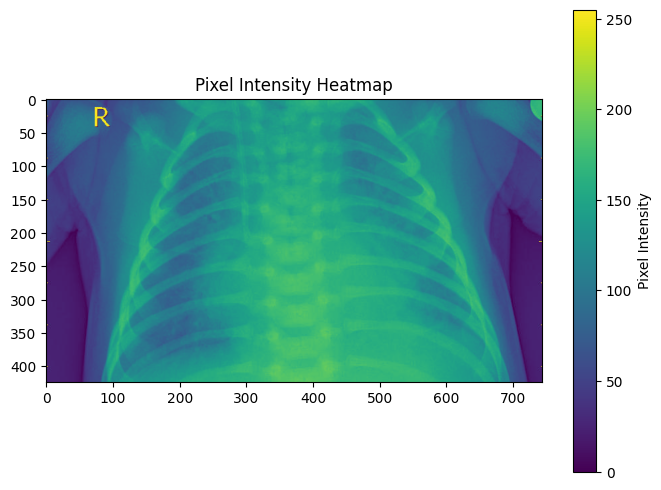

In [ ]:
# As you can see the pixel values are in the range of 0-255 for this img
img = Image.open(img_path).convert("L")
pixels = np.array(img)

plt.figure(figsize=(8,6))
plt.imshow(pixels, cmap='viridis')  # you can use 'gray' too
plt.colorbar(label="Pixel Intensity")
plt.title("Pixel Intensity Heatmap")
plt.show()

In [ ]:
# Lets convert RGB images to grayscale and resize them to 224x224 and normalize them
ROOT_DIR = root_dir

# Keep track of the splits you want to load
SPLITS = ["train", "val", "test"]

# Map string labels to integers for model-friendly targets
LABEL_MAP = {"NORMAL": 0, "PNEUMONIA": 1}

def load_split(split_name, target_size=(224, 224), normalize=True):
    """
    Read every image inside ROOT_DIR / split_name / class_label,
    convert it to grayscale, resize, normalize (optional),
    expand the channel dimension, and return the images with labels.
    """
    images = []
    labels = []
    bad_files = []

    # Build the split path
    split_path = os.path.join(ROOT_DIR, split_name)

    for class_name, class_index in LABEL_MAP.items():
        class_path = os.path.join(split_path, class_name)
        if not os.path.exists(class_path):
            continue

        # Iterate through files in the class folder
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)

            # Get file extension safely
            _, ext = os.path.splitext(filename)
            if ext.lower() not in {".jpg", ".jpeg", ".png"}:
                continue

            # Read the image directly in grayscale
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                bad_files.append(image_path)
                continue

            # Resize to a fixed target size
            if target_size is not None:
                img = cv2.resize(img, target_size)

            # Normalize pixel values (0–1 range)
            if normalize:
                img = img.astype("float32") / 255.0

            # Expand channel axis to (H, W, 1)
            img = np.expand_dims(img, axis=-1)

            images.append(img)
            labels.append(class_index)

    if bad_files:
        print(f"[WARNING] Skipped {len(bad_files)} corrupted files in '{split_name}'")

    return images, labels


# Load every split using the reusable function
x_train, y_train = load_split("train")
x_val, y_val     = load_split("val")
x_test, y_test   = load_split("test")

# Convert lists to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_val,   y_val   = np.array(x_val),   np.array(y_val)
x_test,  y_test  = np.array(x_test),  np.array(y_test)

# Display the dataset stats
print(f"Train set: {x_train.shape}, labels: {y_train.shape}")
print(f"Validation set: {x_val.shape}, labels: {y_val.shape}")
print(f"Test set: {x_test.shape}, labels: {y_test.shape}")

# Show class balance
print("Class balance in train:", Counter(y_train))
print("Class balance in val:  ", Counter(y_val))
print("Class balance in test: ", Counter(y_test))

Train set: (5216, 224, 224, 1), labels: (5216,)
Validation set: (338, 224, 224, 1), labels: (338,)
Test set: (301, 224, 224, 1), labels: (301,)
Class balance in train: Counter({np.int64(1): 3875, np.int64(0): 1341})
Class balance in val:   Counter({np.int64(1): 207, np.int64(0): 131})
Class balance in test:  Counter({np.int64(1): 191, np.int64(0): 110})


# Converting to pytorch required shapes

In [ ]:
# Convert your existing NumPy arrays to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_train_tensor = torch.LongTensor(y_train)

x_val_tensor = torch.FloatTensor(x_val).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_val_tensor = torch.LongTensor(y_val)

x_test_tensor = torch.FloatTensor(x_test).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_test_tensor = torch.LongTensor(y_test)

print(f"Train: {x_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Val: {x_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Test: {x_test_tensor.shape}, {y_test_tensor.shape}")

Train: torch.Size([5216, 1, 224, 224]), torch.Size([5216])
Val: torch.Size([338, 1, 224, 224]), torch.Size([338])
Test: torch.Size([301, 1, 224, 224]), torch.Size([301])


# Creating datasets and dataloader for pytorch

In [ ]:
class chestXraydataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
train_dataset = chestXraydataset(x_train_tensor, y_train_tensor)
val_dataset = chestXraydataset(x_val_tensor, y_val_tensor)
test_dataset = chestXraydataset(x_test_tensor, y_test_tensor)

Since number of smaples in each class are different, instead of manually balancing our data. We can use weighted sampling with pytorch data loader. In this way, we will be able to sample from the minority class more than the manjority class and therefore balancing the data during trining.

In [ ]:
%%time
# Calculate class weights for sampler
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {0: total_samples / class_counts[0],  # NORMAL
                 1: total_samples / class_counts[1]}   # PNEUMONIA

# Create sample weights for each training example
sample_weights = [class_weights[label.item()] for label in y_train_tensor]

# Create weighted sampler
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


train_loader = DataLoader(train_dataset, batch_size=32, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

CPU times: user 4.76 ms, sys: 0 ns, total: 4.76 ms
Wall time: 4.63 ms


# Building CNN model

In [ ]:
class CNNmodel(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):  # 1 in channels: Grayscaled images, 2 classes: NORMAL and PNEUMONIA
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),    # 3x3 conv
                nn.BatchNorm2d(out_c),                   # BatchNorm
                nn.ReLU(inplace=True),                   # Relu
                nn.Conv2d(out_c, out_c, 3, padding=1),   # 3x3 conv (more complex features)
                nn.BatchNorm2d(out_c),                   # BatchNorm
                nn.ReLU(inplace=True),                   # Relu
                nn.MaxPool2d(2)                          # MaxPol (reduce dimensions by half)
            )

        self.layer1 = conv_block(in_channels, 32)        # first conv block (1 -> 32)
        self.layer2 = conv_block(32, 64)                 # second conv block (32 -> 64)
        self.layer3 = conv_block(64, 128)                # third conv block (64 -> 128)
        self.layer4 = conv_block(128, 256)               # forth conv block (128 -> 256)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # converts size to (256, 1, 1)
        self.dropout = nn.Dropout(0.4)                   # random 40% dropout
        self.fc = nn.Linear(256, num_classes)            # fully connected layer (256 -> 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# Initialize the model
model = CNNmodel(num_classes=2)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 1,174,114


Epoch [1/20]
Train Loss: 0.2397, Train Acc: 90.97%
Val Loss: 1.9578, Val Acc: 61.24%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.1528, Train Acc: 94.23%
Val Loss: 0.8014, Val Acc: 74.85%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.1077, Train Acc: 96.01%
Val Loss: 1.1719, Val Acc: 72.19%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.0976, Train Acc: 96.43%
Val Loss: 0.5563, Val Acc: 79.88%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.0859, Train Acc: 96.88%
Val Loss: 0.8938, Val Acc: 77.51%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.0923, Train Acc: 96.49%
Val Loss: 1.7266, Val Acc: 64.79%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.0592, Train Acc: 97.74%
Val Loss: 0.8188, Val Acc: 78.40%
--------------------------------------------------
Epoch [8/20]
Train Loss: 0.0578, Train Acc: 97.8

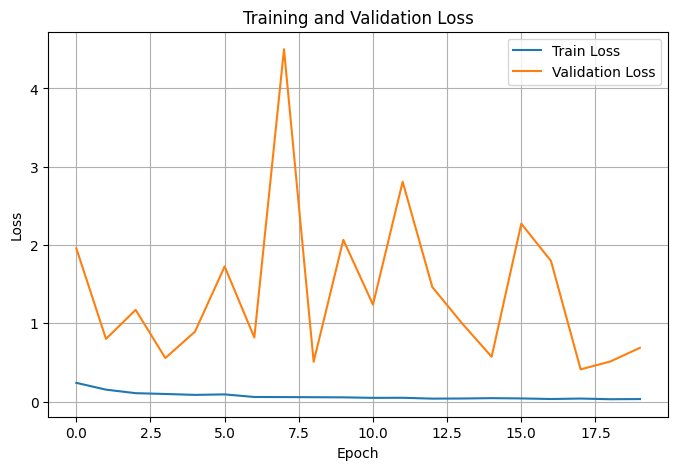

In [20]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

# Move data to device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    


# Training loop with loss tracking
def train_model(model, train_loader, val_loader, epochs=20):
    best_val_acc = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = to_device(images, device), to_device(labels, device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = train_loss / train_total
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = to_device(images, device), to_device(labels, device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / val_total
        val_losses.append(epoch_val_loss)

        # Accuracy
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/model/best_pneumonia_model.pth')

    print(f'Best validation accuracy: {best_val_acc:.2f}%')

    # Plot losses
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

In [22]:
%%time
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Model evaluation
def evaluate_model(model, test_loader):
    model.eval()
    model.load_state_dict(torch.load('/home/fahimeh/workspace/Data_science_projects/CNN_Chest_Xray_Project/model/best_pneumonia_model.pth'))

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = to_device(images, device), to_device(labels, device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())  # Pneumonia probability

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test AUC: {auc:.4f}")

# Evaluate
evaluate_model(model, test_loader)

Test Accuracy: 0.8870
Test Precision: 0.8876
Test Recall: 0.8870
Test F1-Score: 0.8852
Test AUC: 0.9513
CPU times: user 713 ms, sys: 7.07 ms, total: 720 ms
Wall time: 347 ms


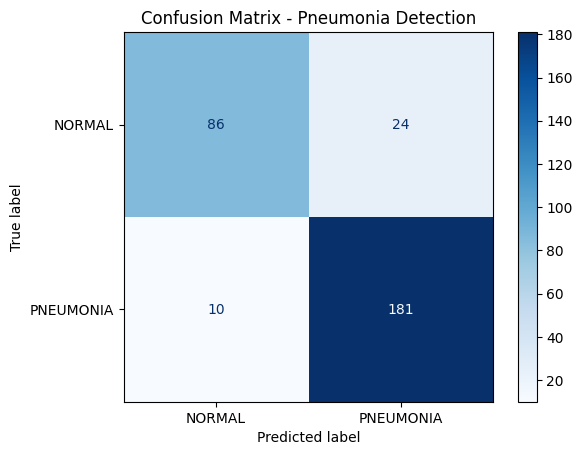

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix_simple(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=["NORMAL", "PNEUMONIA"], cmap="Blues", values_format="d"

    )
    disp.ax_.set_title("Confusion Matrix - Pneumonia Detection")
    plt.show()

plot_confusion_matrix_simple(model, test_loader, device)